In [1]:
from ValueIteration import value_iteration
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import math
import itertools

# Implementing Value Iteration to solve 2-echelon inventory optimisation MDPs

## No lead times

In [24]:

# Function to create transition probability function
def create_P(S, A, state_idx, action_idx, demand_distribution, capacity):
    def prob_trans(s, a, sp):
        ''' Calculates the probability of transition from state s to s' under action a'''
        prob = 0
        new_IL = s + a
        demand = new_IL - sp
        if new_IL > capacity: # if on-hand stock exceeds DC capacity initially
            if sp < capacity: # but next state is not a truncated state
                prob = demand_distribution.get(demand, 0)
            elif sp >= capacity: # and next state is a truncated state - take sum of relevant demand probabilities
                prob = sum(demand_distribution[d] for d in demand_distribution if new_IL - d >= capacity)

        elif new_IL - max(demand_distribution) >= -capacity: # if backlogs are not beyond limit
            prob = demand_distribution.get(demand, 0)

        elif new_IL - max(demand_distribution) < -capacity: # if backlogs are beyonf limit
            if sp > -capacity: # but next state is not truncated
                prob = demand_distribution.get(demand, 0)
            elif sp <= -capacity: # and next state is truncated - take sum of relevant demand probabilities
                prob = sum(demand_distribution[d] for d in demand_distribution if new_IL - d <= -capacity)
            
        return prob

    P_array = np.zeros((len(S), len(A), len(S)))

    for s in S:
        s_idx = state_idx[s]
        for a in A:
            a_idx = action_idx[a]
            for sp in S:
                sp_idx = state_idx[sp]
                P_array[s_idx, a_idx, sp_idx] = prob_trans(s, a, sp)

    return P_array


# Function to create reward function given demand distribution and cost parameters
def create_R(S, A, state_idx, action_idx, demand_distribution, hold_cost, backlog_cost, order_cost):
    def cost_function(s, a):
        ''' Calculates the cost incurred if action a is taken at state s'''
        holding_cost = hold_cost*(sum(max(s + a - dt, 0)*prob for dt, prob in demand_distribution.items()))
        backlogged_cost = backlog_cost*(sum(max(dt - s - a, 0)*prob for dt, prob in demand_distribution.items()))
        ordering_cost = order_cost*a

        return holding_cost + backlogged_cost + ordering_cost

    R_array = np.zeros((len(S), len(A)))

    for s in S:
        s_idx = state_idx[s]
        for a in A:
            a_idx = action_idx[a]
            R_array[s_idx, a_idx] = cost_function(s, a)

    return R_array




# Function to calculate Bellman's equation for a given state (depends on capacity of warehouse and state)
def value_update_func(state_idx, action_idx, capacity, demand_distribution):
    def bellman_eq_no_lead(s, S, A, P, R, gamma, Vk):
        ''' Calculates the values from taking each action at state s'''
        s_idx = state_idx[s]
        values = dict((a, 0) for a in A if s+a <= capacity and s+a-max(demand_distribution) >= -capacity) # stores value function at s for each action
        
        for a in values.keys(): # value for each action
            a_idx = action_idx[a]
            values[a] = R[s_idx, a_idx] + gamma*sum([P[s_idx, a_idx, state_idx[sp]]*Vk[sp] for sp in S])
        return values
    
    return bellman_eq_no_lead



def plot_1ech_L0(optimal_dict, capacity, A, cb, ch, plot_type="policy", savefig=True):
    y_title = "Optimal order quantity" if plot_type == "policy" else "Cost"
    fig, ax = plt.subplots()
    plt.plot(*zip(*sorted(optimal_dict.items())))
    plt.xlabel("Inventory level", fontsize=14)
    plt.ylabel(y_title, fontsize=14)
    plt.grid()
    plt.tight_layout()
    if savefig:
        plt.savefig(f"Figures/single_echelon/{plot_type}_L0_cap{capacity}_moq{max(A)}_sl{cb*100/(cb+ch):.1f}.pdf", dpi=300)
    plt.show()

Converged!
Time taken to solve/converge: 19.978 seconds


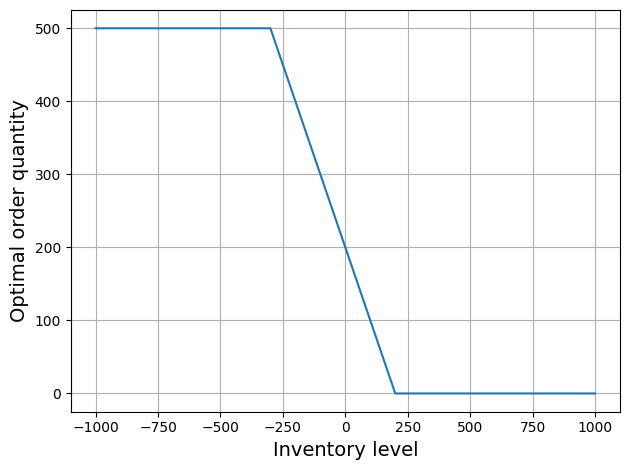

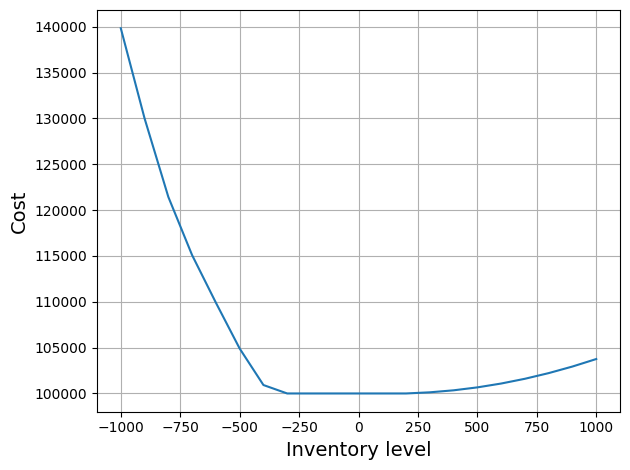

In [36]:
# Setting Problem Parameters
capacity = 1000
demand_dist = {0: 0.2, 100: 0.6, 200: 0.2}     # demand distribution
ch = 1                                         # holding costs (overage)
cb = 50                                        # backlog costs (underage)
cs = 0                                         # ordering/shipping costs

S = sorted(set(int(x) for x in np.arange(-capacity, capacity+1, 100)))
A = sorted(set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, 100)))   # (multiples of 100)
state_idx = {s: i for i, s in enumerate(S)}
action_idx = {a: i for i, a in enumerate(A)}
P = create_P(S, A, state_idx, action_idx, demand_dist, capacity)            # probability of transition
R = create_R(S, A, state_idx, action_idx, demand_dist, ch, cb, cs)          # cost function
V_init = dict([(s, 0) for s in S])             # initial costs at all states is 0
gamma=0.999                                    # discount factor for value iteration
bellman_eq_no_lead = value_update_func(state_idx, action_idx, capacity, demand_dist)


# Calculate and store results
start_time = time.perf_counter()
results_no_lead = value_iteration(S=S, A=A, P=P, R=R, gamma=0.999, max_iterations=100000, 
                          bellman_eq=bellman_eq_no_lead, V_init=V_init, theta=1e-8)
time_nolead = time.perf_counter() - start_time
optimal_policy_no_lead = results_no_lead["optimal_policy"]  
cost_function_no_lead = results_no_lead["value_function"]

print(f"Time taken to solve/converge: {time_nolead:.3f} seconds")
plot_1ech_L0(optimal_policy_no_lead, capacity, A, cb, ch)
plot_1ech_L0(cost_function_no_lead, capacity, A, cb, ch, plot_type="cost")


In [ ]:
# # Plotting code side by side
# fig, ax = plt.subplots(1, 2, figsize=(13,6))
# ax[0].plot(*zip(*sorted(optimal_policy_no_lead.items())))
# ax[0].set(title="Optimal ordering policy at DC", xlabel="Inventory level (in units)", 
# ylabel = "Optimal order quantity (in units)")
# ax[0].grid()
# ax[1].plot(*zip(*sorted(cost_function_no_lead.items())))
# ax[1].set(title="Minimised costs at DC", xlabel="Inventory level (in units)", 
# ylabel = "Cost")
# ax[1].grid()
# plt.suptitle("Optimal ordering policy and costs at DC")
# plt.tight_layout()
# plt.show()

# Implementing Value Iteration to solve 2-echelon inventory optimisation MDP with lead times

In [2]:
# Function to create transition probability function
def create_lead_P(S, A, state_idx, action_idx, demand_distribution, capacity):
    def prob_trans(s, a, sp):
        ''' Calculates the probability of transition from state s to s' under action a'''
        prob = 0 # default transition probability
        
        if sp[1:] == (a,) + s[1:-1]: # check updated orders yet to arrive in new state
            new_IL = s[0] + s[-1]
            demand = new_IL - sp[0]  # demand in time period
            
            if new_IL > capacity: # if on-hand stock exceeds DC capacity
                if sp[0] < capacity: # not a truncated state
                    prob = demand_distribution.get(demand, 0)
                elif sp[0] >= capacity: # truncated state - take sum of relevant demand probabilities
                    prob = sum(demand_distribution[d] for d in demand_distribution if new_IL - d >= capacity)

            elif new_IL - max(demand_distribution) >= -capacity: # if backlogs are not beyond limit
                prob = demand_distribution.get(demand, 0) 

            elif new_IL - max(demand_distribution) < -capacity: # if backlogs are beyond limit
                if sp[0] > -capacity: # not a truncated state
                    prob = demand_distribution.get(demand, 0)
                elif sp[0] <= -capacity: # truncated state - take sum of relevant demand probabilities
                    prob = sum(demand_distribution[d] for d in demand_distribution if new_IL - d <= -capacity)
                    
                    
        return prob

    # array to store transition probabilities for all combinations of s, a, s'
    P_array = np.zeros((len(S), len(A), len(S)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            for sp in S: # for each new state s'
                sp_idx = state_idx[sp]
                # calculate and store probability of transitioning to s' from s under a
                P_array[s_idx, a_idx, sp_idx] = prob_trans(s, a, sp)

    return P_array





# Function to create the cost function given demand distribution and cost parameters
def create_lead_R(S, A, state_idx, action_idx, demand_distribution, hold_cost, backlog_cost, order_cost):
    def cost_function(s, a):
        ''' Calculates the cost incurred if action a is taken at state s'''
        holding_cost = hold_cost*(sum(max(s[0] + s[-1] - dt, 0)*prob for dt, prob in demand_distribution.items()))
        backlogged_cost = backlog_cost*(sum(max(dt - s[0] - s[-1], 0)*prob for dt, prob in demand_distribution.items()))
        ordering_cost = order_cost*a

        return holding_cost + backlogged_cost + ordering_cost


    # array to store rewards for all combinations of s, a
    R_array = np.zeros((len(S), len(A)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            # calculate and store reward gained from s under a
            R_array[s_idx, a_idx] = cost_function(s, a)

    return R_array


# Function to calculate Bellman's equation for a given state (depends on capacity of warehouse and state)
def lead_value_update_func(state_idx, action_idx, capacity):
    def bellman_eq_lead(s, S, A, P, R, gamma, Vk):
        ''' Calculates the values from taking each action at state s'''
        s_idx = state_idx[s]
        values = dict((a, 0) for a in A if sum(s)+a <= capacity) # stores value function at s for each action
        if not values: # if inventory position > capacity, then no units to be ordered
            values = {0: 0}
        
        for a in values.keys():
            a_idx = action_idx[a]
            values[a] = R[s_idx, a_idx] + gamma*sum([P[s_idx, a_idx, state_idx[sp]]*Vk[sp] for sp in S])
        return values
    return bellman_eq_lead



# Function to plot cost or policy vs inventory level given a possible combination of orders are due to arrive
def plot_per_lead_order(optimal_policy, cost_function, possible_lead_order, lead_time, capacity):
    # # If inventory level = x_t + q_{t-L}
    # eligible_keys = [key for key in sorted(optimal_policy) if key[1:-1] == possible_lead_order]
    # inv_levels = [key[0]+key[-1] for key in eligible_keys]
    # opt_policy = [optimal_policy[key] for key in eligible_keys]
    # opt_cost = [cost_function[key] for key in eligible_keys]

    # If inventory level = x_t
    eligible_keys = [key for key in sorted(optimal_policy) if key[1:] == possible_lead_order]
    inv_levels = [key[0] for key in eligible_keys]
    opt_policy = [optimal_policy[key] for key in eligible_keys]
    opt_cost = [cost_function[key] for key in eligible_keys]

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    # Plot optimal policy vs inventory position
    ax[0].plot(inv_levels, opt_policy)
    ax[0].set(title = "Optimal ordering policy at DC", xlabel="Inventory level (in units)", ylabel="Optimal order quantity (in units)")
    ax[0].grid()

    # Plot cost vs inventory position
    ax[1].plot(inv_levels, opt_cost)
    ax[1].set(title = "Minimised costs at DC", xlabel="Inventory level (in units)", ylabel="Cost")
    ax[1].grid()
    plt.suptitle(f"Optimal order policy and cost when orders to arrive are {possible_lead_order}")
    plt.savefig(f"Figures/Optimal_policy_cost_ordersonway_{possible_lead_order}_L{lead_time}_cap{capacity}_moq{max(A)}.png", dpi=300)
    plt.show()

In [3]:
capacity = 1000
order_set = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, 100))        # set of possible order quantities
inventory_set = set(int(x) for x in np.arange(-capacity, capacity + 1, 100))       # set of possible inventory levels
lead_time = 2                                                                      # lead time

# State space and action space
S = set((inv, *arriving_order) for inv in inventory_set for arriving_order in itertools.product(order_set, repeat=lead_time))
A = order_set
state_idx = {s: i for i, s in enumerate(S)}
action_idx = {a: i for i, a in enumerate(A)}
demand_dist = {0: 0.2, 100: 0.6, 200: 0.2}   # demand distribution
ch = 1                                       # holding cost
cb = 50                                      # backlog cost
cs = 0                                       # shipping/ordering costs
P = create_lead_P(S, A, state_idx, action_idx, demand_dist, capacity)               # transition probability function
R = create_lead_R(S, A, state_idx, action_idx, demand_dist, ch, cb, cs)   # cost function
V_init = dict([(s, 0) for s in S])           # initial cost is 0 for all states
gamma=0.999                                  # discount factor
bellman_eq_lead = lead_value_update_func(state_idx, action_idx, capacity)

# Run and store results from value iteration
lead_results= value_iteration(S=S, A=A, P=P, R=R, gamma=gamma, max_iterations=1000, 
                          bellman_eq=bellman_eq_lead, V_init=V_init, theta=1e-7)
lead_optimal_policy = lead_results["optimal_policy"]
lead_cost_function = lead_results["value_function"]

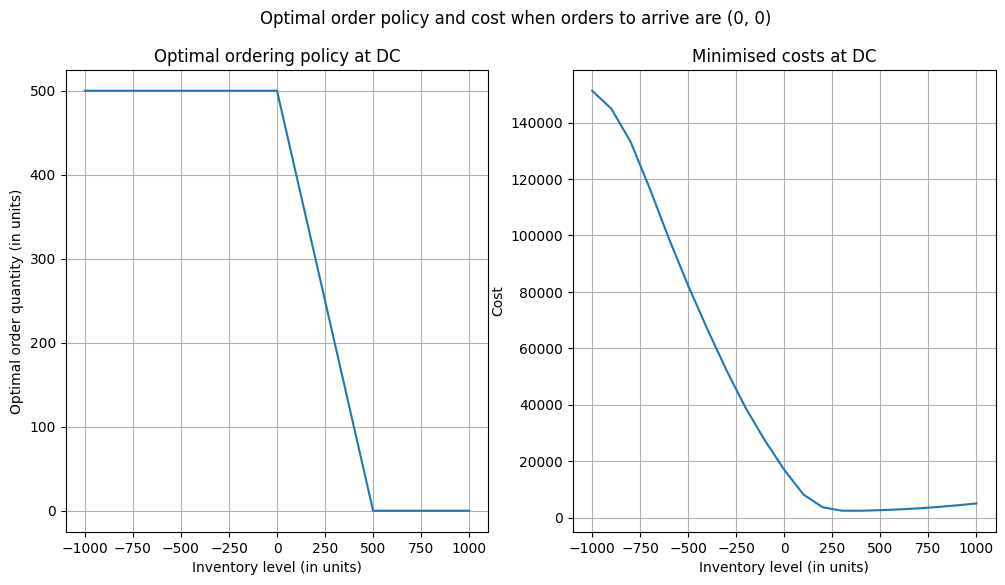

In [ ]:
plot_per_lead_order(lead_optimal_policy, lead_cost_function, (0,0), lead_time, capacity)

In [4]:
# All possible inventory positions
inventory_positions = set(sum(key) for key in lead_optimal_policy)
opt_policy_range = dict([(k, set()) for k in inventory_positions])        # dictionary storing ordering policy values for each inventory position
opt_cost_range = dict([(k, set()) for k in inventory_positions])      # dictionary storing minimised costs for each inventory position
for inv_pos in inventory_positions: # for each possible inventory position
    for key, policy in lead_optimal_policy.items():
        if sum(key) == inv_pos:
            opt_policy_range[inv_pos].add(policy) # add unique policies
    for key, cost in lead_cost_function.items():
        if sum(key) == inv_pos:
            opt_cost_range[inv_pos].add(cost)     # add unique costs


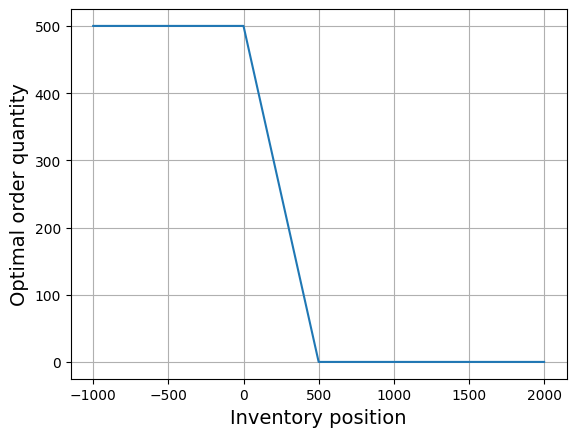

In [5]:
# Plot optimal ordering policy vs inventory position
plt.plot(*zip(*sorted([(ip, pol) for ip, pol_set in opt_policy_range.items() for pol in pol_set])))
plt.xlabel("Inventory position", fontsize=14)
plt.ylabel("Optimal order quantity", fontsize=14)
plt.grid()
plt.savefig(f"Figures/single_echelon/policy_L{lead_time}_cap{capacity}_moq{max(A)}_sl{cb*100/(cb+ch):.1f}.pdf", dpi=300)
plt.show()



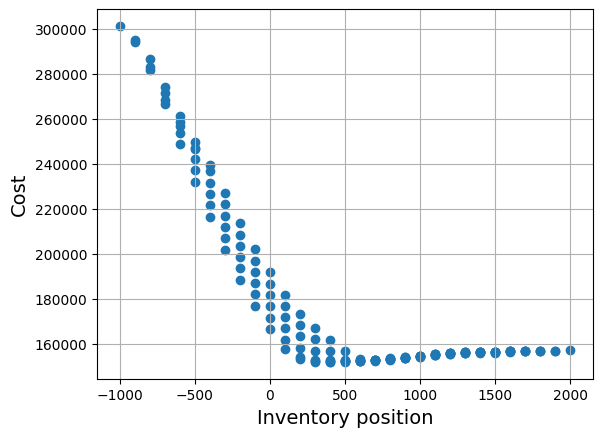

In [6]:
# Plot minimised costs vs inventory position
plt.scatter(*zip(*sorted([(ip, cost) for ip, cost_set in opt_cost_range.items() for cost in cost_set])))
plt.xlabel("Inventory position", fontsize=14)
plt.ylabel("Cost", fontsize=14)
plt.grid()
plt.savefig(f"Figures/single_echelon/cost_L{lead_time}_cap{capacity}_moq{max(A)}_sl{cb*100/(cb+ch):.1f}.pdf", dpi=300)
plt.show()

In [7]:
# Storing inventory position, level, on hand stock, backorders, outstanding orders and the associated policies+costs for each state
ips = []
on_hand_stocks = []
backorders = []
outstanding_stocks = []
policies = []
costs = []

for s in S:
    ips.append(sum(s))
    on_hand_stocks.append(max(s[0]+s[-1], 0))
    backorders.append(max(-(s[0]+s[-1]), 0))
    outstanding_stocks.append(sum(s[1:-1]))
    policies.append(lead_optimal_policy[s])
    costs.append(lead_cost_function[s])



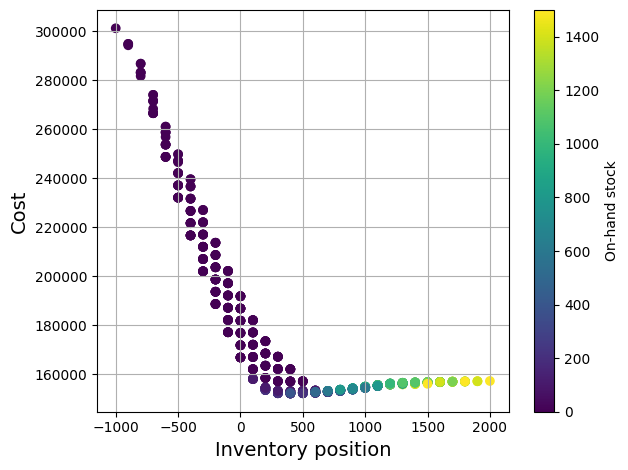

In [8]:
# Plot costs vs inventory position highlighting differences in on-hand stock
scatter = plt.scatter(ips, costs, c=on_hand_stocks, cmap='viridis')
plt.colorbar(scatter, label='On-hand stock')
plt.xlabel('Inventory position', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"Figures/single_echelon/cost_onhand_L{lead_time}_cap{capacity}_moq{max(A)}_sl{cb*100/(cb+ch):.1f}.pdf", dpi=300)
plt.show()

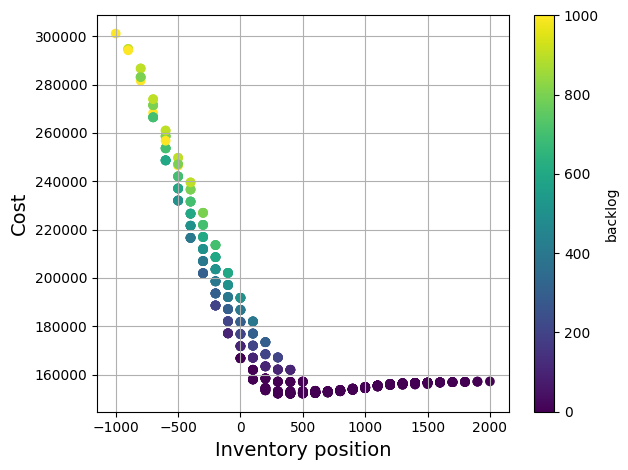

In [9]:
# Plot costs vs inventory position highlighting differences in backlogs
scatter = plt.scatter(ips, costs, c=backorders, cmap='viridis')
plt.colorbar(scatter, label='backlog')
plt.xlabel('Inventory position', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"Figures/single_echelon/cost_backlog_L{lead_time}_cap{capacity}_moq{max(A)}_sl{cb*100/(cb+ch):.1f}.pdf", dpi=300)
plt.show()

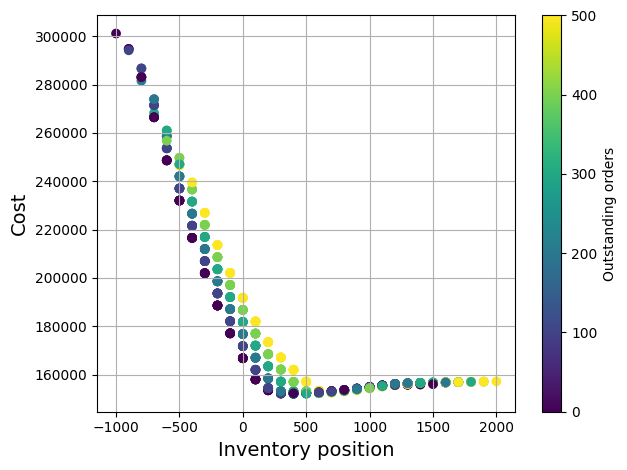

In [11]:
# Plot costs vs inventory position highlighting differences in outstanding orders
scatter = plt.scatter(ips, costs, c=outstanding_stocks, cmap='viridis')
plt.colorbar(scatter, label='Outstanding orders')
plt.xlabel('Inventory position', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"Figures/single_echelon/cost_outstanding_L{lead_time}_cap{capacity}_moq{max(A)}_sl{cb*100/(cb+ch):.1f}.pdf", dpi=300)
plt.show()

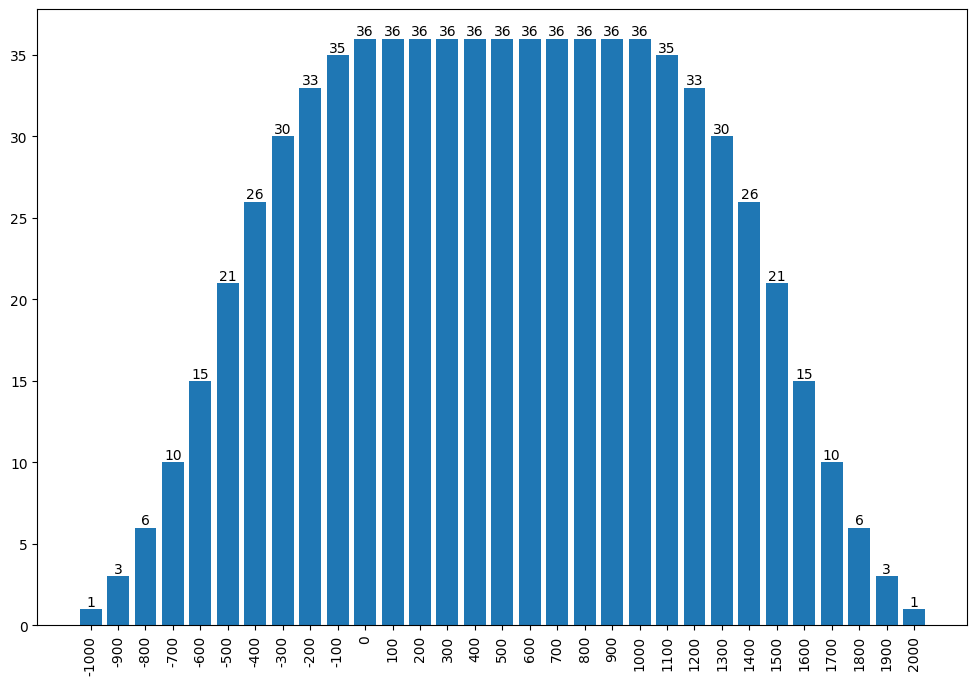

In [ ]:
# Number of states for each inventory position bar plot
ip_unique = list(sorted(inventory_positions))
ip_counts = [ips.count(value) for value in ip_unique]
plt.subplots(figsize=(12,8))
ip_bar = plt.bar(range(len(ip_unique)), ip_counts, tick_label=ip_unique)
plt.bar_label(ip_bar, ip_counts, label_type="edge")
plt.xticks(rotation=90)
plt.show()



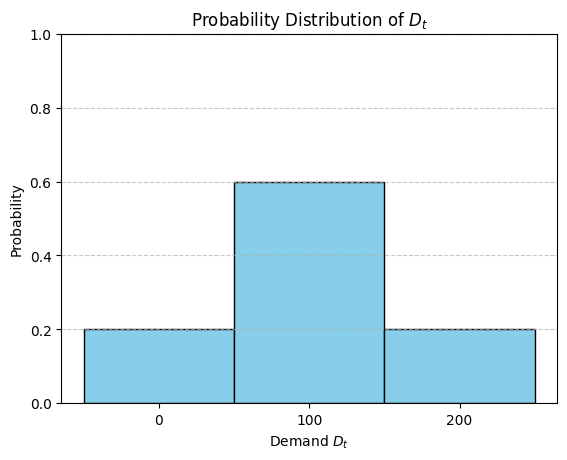

In [33]:
# Discrete values and their probabilities
values = [0, 100, 200]
probs = [0.2, 0.6, 0.2]

# Plot
plt.bar(values, probs, width=100, color='skyblue', edgecolor='black')

plt.xlabel("Demand $D_t$")
plt.ylabel("Probability")
plt.title("Probability Distribution of $D_t$")
plt.xticks(values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)

plt.show()

# Simulation

10800


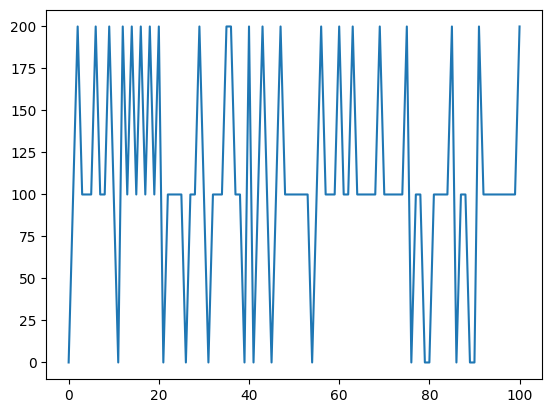

In [34]:
num_periods=100
hold_cost = 1     # holding cost
backlog_cost = 100   # backlog penalty cost
capacity = 1000
initial_inventory = 0

def demand(demand_distribution=demand_dist):
    return np.random.choice([*demand_dist], p=[*demand_distribution.values()])

def simulate_2ech_L0(num_periods=num_periods, il0 = initial_inventory, policy=optimal_policy_no_lead, 
                     h=hold_cost, p=backlog_cost):
    il, total_cost = il0, 0
    states_visited = [il0]
    costs = [total_cost]
    demands = []
    actions= []

    for t in range(num_periods):
        action = policy[il]
        il += action
        d = demand()
        il -= d
        period_cost = max(il, 0)*h + max(-il, 0)*p
        total_cost += period_cost
        states_visited.append(il)
        costs.append(period_cost)
        demands.append(d)
        actions.append(action)

    return states_visited, costs, total_cost

states_seen, costs, total_cost = simulate_2ech_L0()

plt.plot(np.arange(num_periods+1), states_seen,)
# plt.scatter(np.arange(num_periods+1), states_seen, marker=".")
print(total_cost)
        

In [35]:
num_periods=10000
hold_cost = 1     # holding cost
backlog_cost = 100   # backlog penalty cost
capacity = 1000
initial_inventory = (0, 0, 0)

def demand(demand_distribution=demand_dist):
    return np.random.choice([*demand_dist], p=[*demand_distribution.values()])

def simulate_2ech_lead(num_periods=num_periods, ip0 = initial_inventory, 
                       lead_time=2, policy=lead_optimal_policy, 
                     h=hold_cost, p=backlog_cost):
    ip, total_cost = ip0, 0
    states_visited = [ip0]
    costs = [total_cost]
    demands = []
    actions = []

    for t in range(num_periods):
        action = policy[ip]
        new_outstanding_orders = (action, ) + ip[1:-1]
        new_il = ip[0] + ip[-1] 
        d = int(demand())
        new_il -= d
        period_cost = max(new_il, 0)*h + max(-new_il, 0)*p
        total_cost += period_cost
        ip= (new_il, ) + new_outstanding_orders
        demands.append(d)
        states_visited.append(ip)
        costs.append(period_cost)
        actions.append()

    return states_visited, costs, demands, total_cost

states_seen, costs, demands, total_cost = simulate_2ech_lead()
print(total_cost)
# ips = [sum(state) for state in states_seen]
ils = [ip[0] for ip in states_seen]

# plt.plot(ips)


TypeError: list.append() takes exactly one argument (0 given)

In [ ]:
1 - sum([il < 0 for il in ils])/num_periods

0.9902